Shape X: (35995, 7), y: (35995,)
MODELO: RandomForestClassifier (Accuracy = 0.9998)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2149
           1       1.00      1.00      1.00      6850

    accuracy                           1.00      8999
   macro avg       1.00      1.00      1.00      8999
weighted avg       1.00      1.00      1.00      8999

Confusion matrix:
[[2147    2]
 [   0 6850]]

Feature importances (top 20):
final_grade            0.421998
g2                     0.255968
g1                     0.218369
canceled_discipline    0.064633
skipped_discipline     0.033299
period                 0.004425
discipline             0.001308
dtype: float64


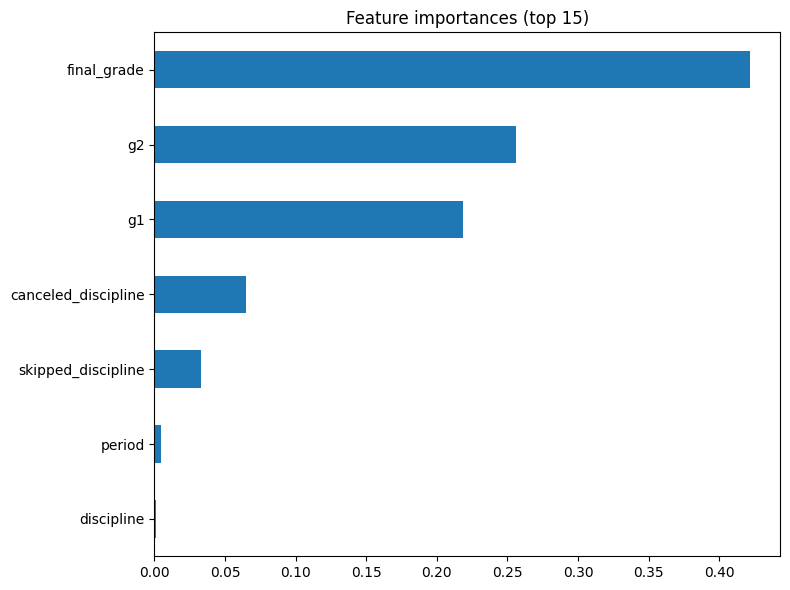


Explicando instância index=34742 com LIME:
[('final_grade <= 0.62', -0.8360298411811292), ('skipped_discipline <= 0.00', 0.5393583810980023), ('canceled_discipline <= 0.00', 0.34628863596529996), ('g2 <= 0.55', -0.11460129272052653), ('g1 <= 0.56', -0.1072878642940228), ('174.00 < discipline <= 286.00', 0.005913723895969444), ('4.00 < period <= 18.00', -0.0054180896469783095)]


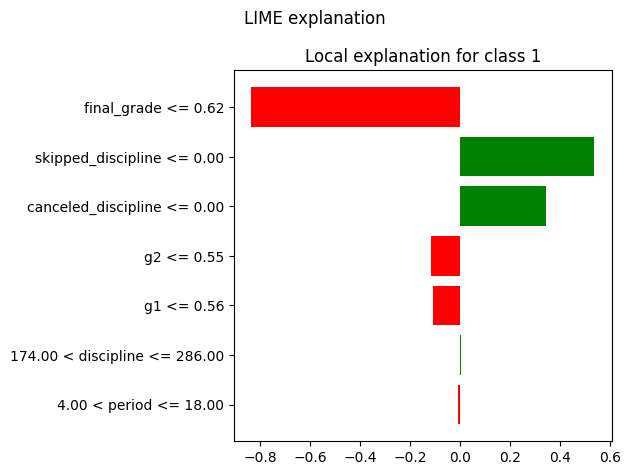


Colunas esperadas: ['period', 'discipline', 'g1', 'g2', 'final_grade', 'canceled_discipline', 'skipped_discipline']

Resultado previsão nova linha: {'prediction': np.int64(1), 'probabilities': {'0': 0.0, '1': 1.0}}


In [4]:
"""
RandomForest + validação + LIME + previsão para linha extra
- Remove colunas não utilizadas: birthdate, sex, city, course, week_day, id, student_id.
- Codifica colunas categóricas (ex: discipline) via LabelEncoder.
- Usa RandomForest (classificação ou regressão conforme status).
- Avalia, mostra importâncias, LIME e permite prever nova linha.
"""

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    mean_squared_error, r2_score
)
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# LIME
from lime.lime_tabular import LimeTabularExplainer

RANDOM_STATE = 42

def load_and_prepare(csv_path: str):
    # Carrega CSV
    df = pd.read_csv(csv_path)

    # Remover colunas que não serão usadas
    cols_to_drop = ["birthdate", "sex", "city", "course", "week_day", "id", "student_id"]
    df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors="ignore")

    if "status" not in df.columns:
        raise ValueError("'status' não encontrado no dataset.")

    # Separar X e y
    X = df.drop(columns=["status"])
    y = df["status"]

    # LabelEncoder para colunas categóricas (object ou string)
    encoders = {}
    for col in X.columns:
        if X[col].dtype == "object":
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
            encoders[col] = le

    return X, y, encoders

def choose_model_by_target(y):
    unique_vals = np.unique(y)
    if len(unique_vals) <= 10:
        return "classifier", RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
    else:
        return "regressor", RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)

def train_and_evaluate(X, y):
    stratify_opt = y if len(np.unique(y)) <= 10 else None
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=stratify_opt
    )

    model_type, model = choose_model_by_target(y_train)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    if model_type == "classifier":
        acc = accuracy_score(y_test, y_pred)
        print(f"MODELO: RandomForestClassifier (Accuracy = {acc:.4f})\n")
        print(classification_report(y_test, y_pred))
        print("Confusion matrix:")
        print(confusion_matrix(y_test, y_pred))
    else:
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        print(f"MODELO: RandomForestRegressor (MSE = {mse:.4f}, R2 = {r2:.4f})\n")

    fi = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    print("\nFeature importances (top 20):")
    print(fi.head(20))

    plt.figure(figsize=(8,6))
    fi.head(15).plot(kind="barh")
    plt.gca().invert_yaxis()
    plt.title("Feature importances (top 15)")
    plt.tight_layout()
    plt.show()

    return model, model_type, X_train, X_test, y_train, y_test

def lime_explain_instance(model, model_type, X_train, X_test, idx=0, num_features=10):
    instance = X_test.iloc[idx]
    print(f"\nExplicando instância index={X_test.index[idx]} com LIME:")

    mode = "classification" if model_type == "classifier" else "regression"
    explainer = LimeTabularExplainer(
        training_data=X_train.values,
        feature_names=X_train.columns.tolist(),
        mode=mode,
        discretize_continuous=True,
        random_state=RANDOM_STATE
    )

    exp = explainer.explain_instance(
        data_row=instance.values,
        predict_fn=(model.predict_proba if model_type == "classifier" else model.predict),
        num_features=num_features
    )
    print(exp.as_list())

    fig = exp.as_pyplot_figure()
    fig.suptitle("LIME explanation")
    plt.tight_layout()
    plt.show()

def predict_new_row(model, model_type, X_columns, encoders, new_row: dict):
    # Codificar colunas categóricas com os encoders usados no treino
    row_fixed = {}
    for col in X_columns:
        val = new_row[col]
        if col in encoders:
            le = encoders[col]
            if val not in le.classes_:
                raise ValueError(f"Valor '{val}' não visto em treino para coluna '{col}'.")
            row_fixed[col] = le.transform([val])[0]
        else:
            row_fixed[col] = val

    df_new = pd.DataFrame([row_fixed[c] for c in X_columns]).T
    df_new.columns = X_columns

    pred = model.predict(df_new.values)
    output = {"prediction": pred[0]}
    if model_type == "classifier":
        probs = model.predict_proba(df_new.values)[0]
        output["probabilities"] = dict(zip(map(str, model.classes_), probs.tolist()))
    return output

if __name__ == "__main__":
    CSV_PATH = "datasets/original_treated.csv"

    X, y, encoders = load_and_prepare(CSV_PATH)
    print(f"Shape X: {X.shape}, y: {y.shape}")

    model, model_type, X_train, X_test, y_train, y_test = train_and_evaluate(X, y)

    lime_explain_instance(model, model_type, X_train, X_test, idx=0, num_features=10)

    # Exemplo de nova linha (preencher valores reais do dataset!)
    example_new_row = {
        "discipline": "Formação Empresarial III",  # string, será convertido
        "period": 4,
        "status": None,  # não precisa, será ignorado
        # "g1": 5.0,
        "g1": 6.0,
        # "g2": 7.0,
        "g2": 7.0,
        # "final_grade": 6.0,
        "final_grade": 7.5,
        "canceled_discipline": 0,
        "skipped_discipline": 0
    }
    # Remover status da previsão
    if "status" in example_new_row:
        example_new_row.pop("status")

    # Ajuste se houver mais colunas
    print("\nColunas esperadas:", X.columns.tolist())
    result = predict_new_row(model, model_type, X.columns.tolist(), encoders, example_new_row)
    print("\nResultado previsão nova linha:", result)
